In [1]:
import lhapdf
#import ROOT
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (7.6,4)
## Getting a PDF member object
p_cteq6 = lhapdf.mkPDF("cteq6l1", 0)
p_cteq18 = lhapdf.mkPDF("CT18qed",0)
JAM20 = lhapdf.mkPDF("JAM20-SIDIS_FF_pion_nlo", 0)
JAM20_PDF = lhapdf.mkPDF("JAM20-SIDIS_PDF_proton_nlo", 0)
from iminuit import Minuit
import sys
sys.path.insert(1,'DSS')
import fDSS_
sys.path.insert(1,'hkns07fflib-v1_2')
import hknsff07_
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares
i_FF = 5
FF_model = ["fDSSLO","fDSSNLO","JAM20","hknsff07_LO","hknsff07_NLO","myDz"]
i_PDF = 1
PDF_model = ["cteq6l1","JAM20","cteq18qed"]
i_assumption = '7ass_'
#i_assumption = '7ass_all_'

LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/CT18qed/CT18qed_0000.dat
CT18qed PDF set, member #0, version 1
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/JAM20-SIDIS_FF_pion_nlo/JAM20-SIDIS_FF_pion_nlo_0000.dat
JAM20-SIDIS_FF_pion_nlo PDF set, member #0, version 2
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/JAM20-SIDIS_PDF_proton_nlo/JAM20-SIDIS_PDF_proton_nlo_0000.dat
JAM20-SIDIS_PDF_proton_nlo PDF set, member #0, version 2


In [2]:
with open('results/yield_ratio_xz_combined_withRungroups.json') as j_RD:
    RDxz = json.load(j_RD)
with open('results/yield_ratio_Q2xzRunG_combined.json') as j_Q2xzRG:
    RD_Q2xzRG = json.load(j_Q2xzRG)
    #colors = ['antiquewhite','antiquewhite4','aqua','aquamarine3','aquamarine4','azure4','banana','bisque4','blue2','blueviolet','brick','brown','burlywood4','cadetblue4','cadmiuorange','chartreuse4','cobalk','cobaltgreen','cornflowerblue','coral4','crimson','darkgoldenrod','darkgreen','darkorange2','darksamon','darkorchid2','darkseagreen4','darkslategrey3','flesh','goldenrod1','green4','hotpink','indianred3','lemonchiffon4','lightblue4','lightgoldenrod4','lightsalmon3','lightsteelblue','manganeseblue','mediumorchid3','mediumturquoise','navy','olive','orange','orangered1','palevioletred','pink3','red2','royalblue2','seagreen3','sienna2','slateblue2','springgreen3','tan2','teal','thistle','tomato1','violetred2','wheat','yellow3']
colors = ['antiquewhite','antiquewhite','aqua','aquamarine','azure','banana','bisque','blue','blueviolet','brown','burlywood','cadetblue','chartreuse','cornflowerblue','coral','crimson','darkgoldenrod','darkgreen','darkorange','darksalmon','darkorchid','darkseagreen','darkslateblue','darkslategrey','darkviolet','dimgray','firebrick','forestgreen','goldenrod','green','greenyellow','hotpink','indigo','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow']
def Get_weighted(values,errs):
    sums = 0
    sig = 0
    for i in range(len(values)):
        for j in range(len(errs)):
            sums+=values[i]/(errs[i]*errs[i])
            sig+=1/(errs[i]*errs[i])
    return sums/sig   
def Get_weighted_average(value,error):
    sum_mean = 0
    sum_sigma = 0
    for i in range(len(value)):
        sum_mean += value[i]/(error[i]*error[i])
        sum_sigma += 1/(error[i]*error[i])
    return sum_mean/sum_sigma
def Get_weighted_sigma(value,error):
    sum_sigma = 0
    for i in range(len(value)):
        sum_sigma += 1/(error[i]*error[i])
    return math.sqrt(1/sum_sigma)

def MRST_CSV(x,k):
    return 2*k*(1-x)**4*x**-0.5*(x-0.0909)




In [3]:
with open('results/CSVs_2dfit.json') as CSV2d_infile:
    j_CSV2d_out=json.load(CSV2d_infile)
def Ax(Q,xbj):
    uv = 0
    dv = 0
    if i_PDF == 0:
        uv = p_cteq6.xfxQ(2,xbj,Q)-p_cteq6.xfxQ(-2,xbj,Q)
        dv = p_cteq6.xfxQ(1,xbj,Q)-p_cteq6.xfxQ(-1,xbj,Q)
    elif i_PDF == 1:
        uv = JAM20_PDF.xfxQ(2,xbj,Q)-JAM20_PDF.xfxQ(-2,xbj,Q)
        dv = JAM20_PDF.xfxQ(1,xbj,Q)-JAM20_PDF.xfxQ(-1,xbj,Q)
    elif i_PDF ==2:
        uv = p_cteq18.xfxQ(2,xbj,Q)-p_cteq18.xfxQ(-2,xbj,Q)
        dv = p_cteq18.xfxQ(1,xbj,Q)-p_cteq18.xfxQ(-1,xbj,Q)
    return -4/(3*(uv+dv))

def Dz(Q,z_had):
    '''
    #Kretzer
    Dd_plus = 0.217*z_had**-1.805*(1-z_had)**2.037
    Du_plus = 0.689*z_had**-1.039*(1-z_had)**1.241 
    delta_z = Dd_plus/Du_plus
    '''
    if i_FF == 0:
        #fDSS lo
        duplus = fDSS_.fdss(1,1,0,z_hadron,Q*Q)[0]
        duminus = fDSS_.fdss(1,-1,0,z_hadron,Q*Q)[0]
        delta_z = duminus/duplus
        return (1-delta_z)/(1+delta_z)
    elif i_FF == 1:
        #fDSS nlo
        duplus = fDSS_.fdss(1,1,1,z_hadron,Q*Q)[0]
        duminus = fDSS_.fdss(1,-1,1,z_hadron,Q*Q)[0]
        delta_z = duminus/duplus
        return (1-delta_z)/(1+delta_z)
    elif i_FF == 2:
        duplus = JAM20.xfxQ(2,z_hadron,Q)
        duminus = JAM20.xfxQ(-2,z_hadron,Q)
        delta_z = duminus/duplus
        return (1-delta_z)/(1+delta_z)
    elif i_FF==3:
        
        ff = np.zeros(11)
        grad = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_hadron,1,1,ff,grad)
        ff_minus = np.zeros(11)
        grad_minus = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_hadron,1,2,ff_minus,grad_minus)
        duplus = ff[6]
        dsplus = ff[8]
        duminus = ff_minus[6]
        dsminus = ff_minus[8]
        delta_z = duminus/duplus
    elif i_FF==4:
        
        ff = np.zeros(11)
        grad = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_hadron,2,1,ff,grad)
        ff_minus = np.zeros(11)
        grad_minus = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_hadron,2,2,ff_minus,grad_minus)
        duplus = ff[6]
        dsplus = ff[8]
        duminus = ff_minus[6]
        dsminus = ff_minus[8]
        delta_z = duminus/duplus
    elif i_FF ==5:
        #first assumption CSV = 0
        '''
        parameters_0=(0.5837438039662431,-1.1844700435399933,1.6742194710533476)
        parameters_1=(0.5487693365000776,-1.0881946339773718,1.594995464377801)
        parameters_2=(0.38322380904636766,-0.47844410509432217,1.115729075281362)
        
        #second assumption, CSV = d
        parameters_0=(0.5993802704632198,-1.1404993637080942,1.649248197183764)
        parameters_1=(0.5495932327086159,-1.0049687610285973,1.5265333016901528)
        parameters_2=(0.3185881810309631,-0.02221386562798845,0.6840309157433447)
        '''
        parameter_0 = []
        parameter_1 = []
        parameter_2 = []
        if(i_assumption == '7ass_'):
            #7 assumption, rho subtracted
            parameters_0 = j_CSV2d_out[(i_assumption+'param')]["1stDzparam"]
            parameters_1 = j_CSV2d_out[(i_assumption+'param')]["2ndDzparam"]
            parameters_2 = j_CSV2d_out[(i_assumption+'param')]["3rdDzparam"]
        elif(i_assumption == '7ass_all_'):
            #7 assumption, all
            parameters_0 = j_CSV2d_out[(i_assumption+'param')]["Dzparam"]
            parameters_1 = j_CSV2d_out[(i_assumption+'param')]["Dzparam"]
            parameters_2 = j_CSV2d_out[(i_assumption+'param')]["Dzparam"]

        def Dz_param(z_had,params):
            delta_z = z_had**params[0]*(1-z_had)**params[1]
            return (1-delta_z)/(1+delta_z)
        if Q<math.sqrt(4.5):
            return Dz_param(z_had,parameters_0)
        elif Q>math.sqrt(5):
            return Dz_param(z_had,parameters_2)
        else:
            return Dz_param(z_had,parameters_1)

    
def Bx(Q,xbj,z_had):
    duplus = 0
    duminus = 0
    dsplus = 0
    dsminus = 0
    delta_z = 0
    
    if i_FF==2:
        duplus = JAM20.xfxQ(2,z_had,Q)
        duminus = JAM20.xfxQ(-2,z_had,Q)
        dsplus = JAM20.xfxQ(3,z_had,Q)
        dsminus = JAM20.xfxQ(-3,z_had,Q)
        delta_z = duminus/duplus
        
    elif i_FF==0:
        duplus = fDSS_.fdss(1,1,0,z_hadron,Q*Q)[0]
        duminus = fDSS_.fdss(1,-1,0,z_hadron,Q*Q)[0]
        dsplus = fDSS_.fdss(1,1,0,z_hadron,Q*Q)[4]
        dsminus = fDSS_.fdss(1,-1,0,z_hadron,Q*Q)[4]
        delta_z = duminus/duplus
    elif i_FF==1:
        duplus = fDSS_.fdss(1,1,1,z_hadron,Q*Q)[0]
        duminus = fDSS_.fdss(1,-1,1,z_hadron,Q*Q)[0]
        dsplus = fDSS_.fdss(1,1,1,z_hadron,Q*Q)[4]
        dsminus = fDSS_.fdss(1,-1,1,z_hadron,Q*Q)[4]
        delta_z = duminus/duplus
        #return (1-delta_z)/(1+delta_z)
    elif i_FF==3:
        
        ff = np.zeros(11)
        grad = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_hadron,1,1,ff,grad)
        ff_minus = np.zeros(11)
        grad_minus = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_hadron,1,2,ff_minus,grad_minus)
        duplus = ff[6]
        dsplus = ff[8]
        duminus = ff_minus[6]
        dsminus = ff_minus[8]
        delta_z = duminus/duplus
    elif i_FF==4:
        
        ff = np.zeros(11)
        grad = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_hadron,2,1,ff,grad)
        ff_minus = np.zeros(11)
        grad_minus = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_hadron,2,2,ff_minus,grad_minus)
        duplus = ff[6]
        dsplus = ff[8]
        duminus = ff_minus[6]
        dsminus = ff_minus[8]
        delta_z = duminus/duplus
    elif i_FF==5:
        duplus = JAM20.xfxQ(2,z_had,Q)
        duminus = JAM20.xfxQ(-2,z_had,Q)
        dsplus = JAM20.xfxQ(3,z_had,Q)
        dsminus = JAM20.xfxQ(-3,z_had,Q)
        delta_z = duminus/duplus
    ubar = 0
    dbar = 0
    uv = 0
    dv = 0
    strange = 0
    sbar = 0
    if i_PDF == 0:
        ubar = p_cteq6.xfxQ(-2,xbj,Q)
        dbar = p_cteq6.xfxQ(-1,xbj,Q)
        uv = p_cteq6.xfxQ(2,xbj,Q)-ubar
        dv = p_cteq6.xfxQ(1,xbj,Q)-dbar
        strange = p_cteq6.xfxQ(3,xbj,Q)
        sbar = p_cteq6.xfxQ(-3,xbj,Q)
    elif i_PDF == 1:
        ubar = JAM20_PDF.xfxQ(-2,xbj,Q)
        dbar = JAM20_PDF.xfxQ(-1,xbj,Q)
        uv = JAM20_PDF.xfxQ(2,xbj,Q)-ubar
        dv = JAM20_PDF.xfxQ(1,xbj,Q)-dbar
        strange = JAM20_PDF.xfxQ(3,xbj,Q)
        sbar = JAM20_PDF.xfxQ(-3,xbj,Q)
    elif i_PDF == 2:
        ubar = p_cteq18.xfxQ(-2,xbj,Q)
        dbar = p_cteq18.xfxQ(-1,xbj,Q)
        uv = p_cteq18.xfxQ(2,xbj,Q)-ubar
        dv = p_cteq18.xfxQ(1,xbj,Q)-dbar
        strange = p_cteq18.xfxQ(3,xbj,Q)
        sbar = p_cteq18.xfxQ(-3,xbj,Q)
    B_NS = 5*(ubar+dbar)/(uv+dv)
    B_sz = (dsplus+dsminus)/duplus/(1+delta_z) 
    B_S = B_sz*(strange+sbar)/(uv+dv)
    return 5/2+B_NS+B_S
 


def CSVx(Q,z_had,xbj,RDmeas):
    return (Bx(Q,xbj,z_had)-Dz(Q,z_had)*(RDmeas+2.5))/Ax(Q,xbj)
def CSVx_err(Q,z_had,xbj,RDmeas):
    return Dz(Q,z_had)*(RDmeas)/Ax(Q,xbj)

In [4]:
Q2s = [3.80473,4.56863,5.19412]
Q2_str = ["4.000000","4.750000","5.500000"]

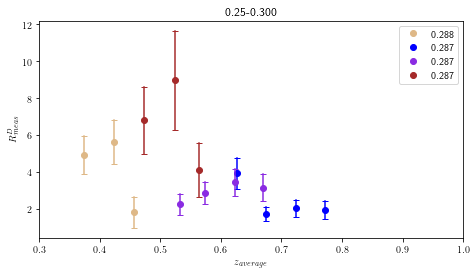

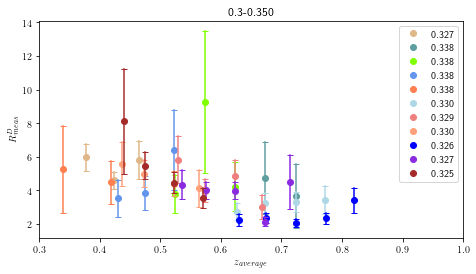

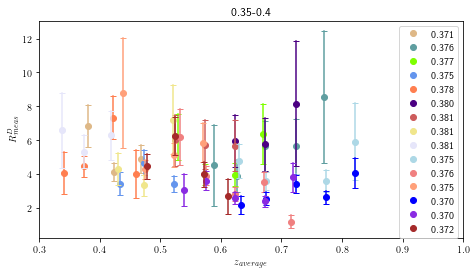

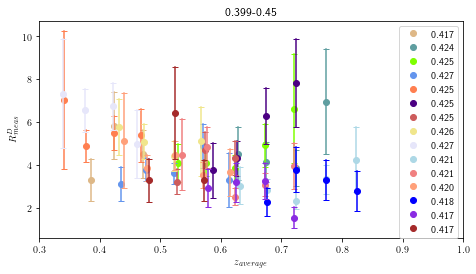

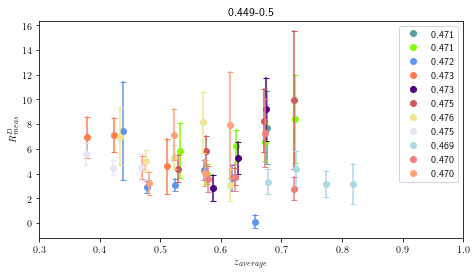

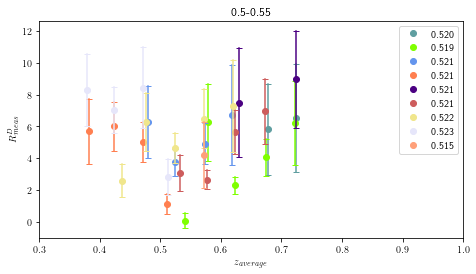

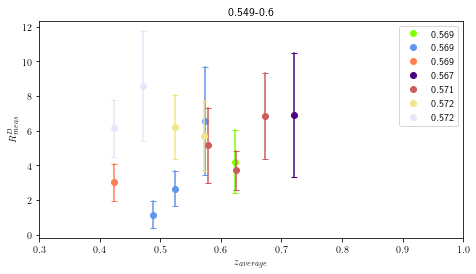

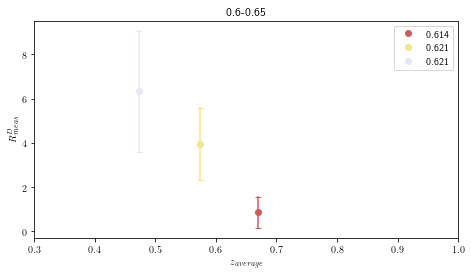

In [5]:
Q2 = Q2s[0]
#RDs_xbj = []
#RDs_xbj_err = []
for key_xbj,xbj_value in RDxz[Q2_str[0]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    
    #print(xbj)
    #color = ['b','g','r','c','m','y','firebrick','salmon','sienna','orange','tan','peachpuff','teal','hotpink']
    for key_rungroup,rungroup_value in xbj_value.items():
        RunGroup = int(key_rungroup)
        zs = []
        RDs = []
        RDs_error = []
        #print(RunGroup)
        xbj_corrs = []
        xbj_corr_errs = []
        for key_z, z_value in rungroup_value.items():
            z_hadron = float(key_z)#+0.0001*RunGroup
            #print(z_hadron)
            #zs.append(z_hadron)
            RDi=float(z_value["value"])
            RDi_error = float(z_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(z_value["z_corr"])
            zs.append(zi_corr)
            xbji_corr = float(z_value["xbj_corr"])
            #print(z_value["xbj_corr"])
            xbji_corr_err = float(z_value["xbj_corr_err"])
            xbj_corrs.append(xbji_corr)
            xbj_corr_errs.append(xbji_corr_err)
            ax.plot([zi_corr,zi_corr],[RDi+RDi_error,RDi-RDi_error],marker="_",color = colors[RunGroup//10])
        
        xbj_corr = Get_weighted(xbj_corrs,xbj_corr_errs)
        #print(xbj_corr)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_corr_str = str(xbj_corr)
        plt.plot(zs,RDs,"o",color = colors[RunGroup//10],label = xbj_corr_str[0:5])
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
        #RD_xbj = Get_weighted_average(RDs,RDs_error)
        #RD_xbj_err = Get_weighted_sigma(RDs,RDs_error)
        #RDs_xbj.append(RD_xbj)
        #RDs_xbj_err.append(RD_xbj_err)
        

In [6]:
#RDs_xbj = []
#RDs_xbj_err = []

#ones Q2 = 5.5, twos Q2 = 4.75, threes Q2 = 4,
xbj_ones_corr = []
xbj_ones_err = []
CSV_ones = []
CSV_ones_err = []
xbj_ones_plot = []
CSV_ones_plot = []
CSV_ones_err_plot = []
xbj_twos_corr = []
xbj_twos_err = []
CSV_twos = []
CSV_twos_err = []
xbj_twos_plot = []
CSV_twos_plot = []
CSV_twos_err_plot = []
xbj_threes_corr = []
xbj_threes_err = []
CSV_threes = []
CSV_threes_err = []
xbj_threes_plot = []
CSV_threes_plot = []
CSV_threes_err_plot = []

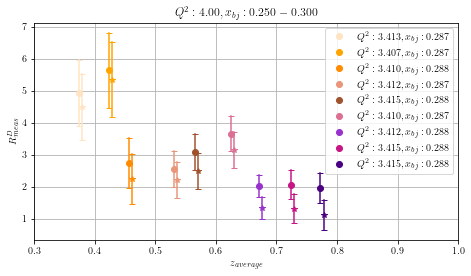

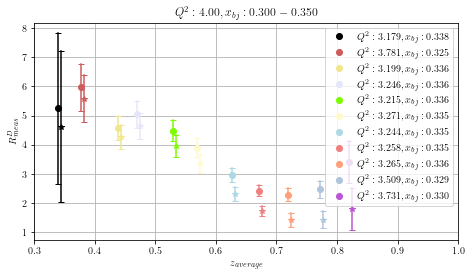

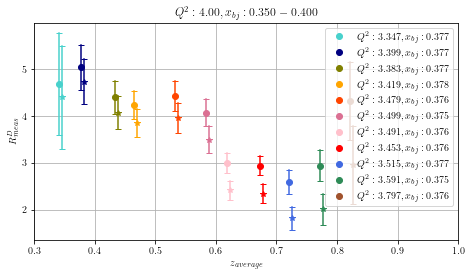

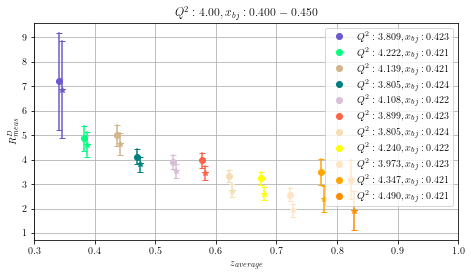

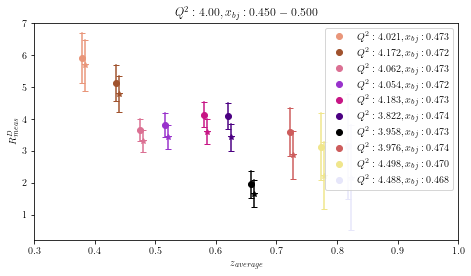

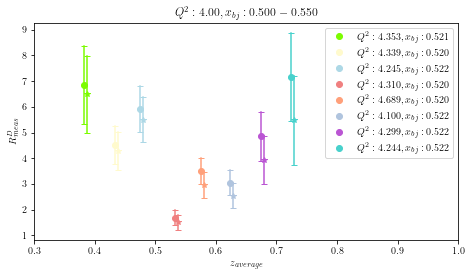

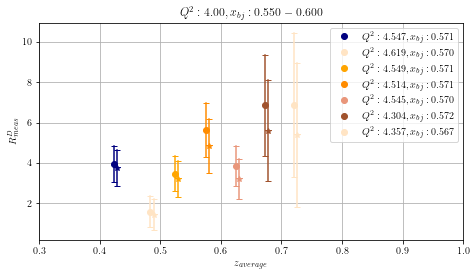

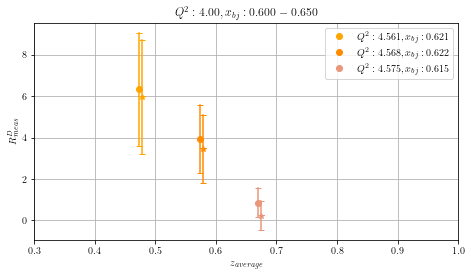

In [7]:
CSVs = []
CSVs_err = []
xbj_all_corr=[]
i_col = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow','bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','bisque','orange','darkorange','darksalmon','sienna','bisque','orange','darkorange','darksalmon','sienna']


for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[0]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    xbj_one_corr = []
    xbj_one_err_corr = []
    CSV_one = []
    CSV_one_err = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_rho = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_rho=float(RunGroup_value["RD_rho"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_rho.append(RDi_rho)
            RDs_error.append(RDi_error)
            #print('RD_error ',RD_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = float(RunGroup_value["Q2_corr"])
            Q2i_corr_err = float(RunGroup_value["Q2_corr_err"])
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            if Q2i_corr<3:
                print(Q2i_corr)
         
            CSVxzi = CSVx(math.sqrt(Q2i_corr),zi_corr,xbji_corr,RDi)
            CSVxzi_err = CSVx_err(math.sqrt(Q2i_corr),zi_corr,xbji_corr,RDi_error)
            CSV_ones.append(CSVxzi)
            CSV_ones_err.append(CSVxzi_err)
            xbj_ones_corr.append(xbji_corr)
            
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        if abs(xbj_corr-xbj)>0.025:
            print(xbj_corr-xbj)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        Q2_corr = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        if Q2_corr<3:
            print("corr ",Q2_corr)
        #print('RDs ',RDs)
        #print('RDs err ',RDs_error)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        RD_rho = Get_weighted_average(RDs_rho,RDs_error)
        #print('RD',RD)
        #print('RD_err',RD_err)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        ax.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],color = colors_all[i_col],marker = "_")
        plt.plot(z_corr,RD,"o",color = colors_all[i_col],label = f"$Q^2:{Q2_corr:.3f},x_{{bj}}:{xbj_corr:.3f}$")
        ax.plot([z_corr+0.005,z_corr+0.005],[RD_rho+RD_err,RD_rho-RD_err],marker = "_",color = colors_all[i_col])
        plt.plot(z_corr+0.005,RD_rho,"*",color = colors_all[i_col])
        xbj_all_corr.append(xbj_corr)
        CSVxi = CSVx(math.sqrt(Q2_corr),z_corr,xbj_corr,RD)
        CSVxi_err = CSVx_err(math.sqrt(Q2_corr),z_corr,xbj_corr,RD_err)
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_one_corr.append(xbj_corr)
        xbj_onei_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_one_err_corr.append(xbj_onei_err_corr)
        CSV_one.append(CSVxi)
        CSV_one_err.append(CSVxi_err)
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        plt.grid()
        ax.set_title(f"$Q^2:{Q2_str[0][0:4]},x_{{bj}}:{(xbj-0.025):.3f}-{(xbj+0.025):.3f}$")#str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
        i_col = i_col+1
    xbj_one = Get_weighted_average(xbj_one_corr,xbj_one_err_corr)
    xbj_ones_plot.append(xbj_one)
    #print(xbj_one_corr)
    #print('corredted',xbj_one)
    xbj_one_err = Get_weighted_average(xbj_one_corr,xbj_one_err_corr)
    #xbj_ones_err.append(xbj_one_err)
    #print('CSVs',CSV_one)
    #print('CSCVs err',CSV_one_err)
    CSVxi_one = Get_weighted_average(CSV_one,CSV_one_err)
    CSVxi_one_err = Get_weighted_sigma(CSV_one,CSV_one_err)
    #print('CSV one', CSVxi_one)
    #print('CSV one err',CSVxi_one_err)
    #print(CSV_one_err)
    #print(CSVxi_one_err)
    CSV_ones_plot.append(CSVxi_one)
    CSV_ones_err_plot.append(CSVxi_one_err)

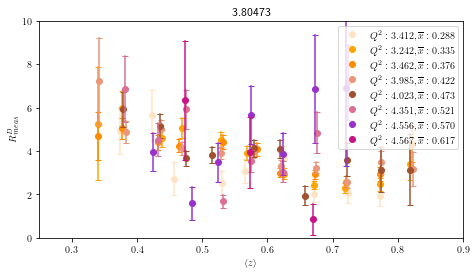

In [8]:

i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[0]].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    xbj_corr_xbj = []
    xbj_err_xbj = []
    Q2_corr_xbj = []
    Q2_err_xbj = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = float(RunGroup_value["Q2_corr"])
            Q2i_corr_err = float(RunGroup_value["Q2_corr_err"])
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr_z = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        Q2_err_z = Get_weighted_sigma(Q2s_corr,Q2s_corr_err)
        Q2_corr_xbj.append(Q2_corr_z)
        Q2_err_xbj.append(Q2_err_z)
        xbj_corr_z = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_corr_err_z = Get_weighted_sigma(xbjs_corr,xbjs_corr_err)
        xbj_corr_xbj.append(xbj_corr_z)
        xbj_err_xbj.append(xbj_corr_err_z)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    Q2_corr = Get_weighted_average(Q2_corr_xbj,Q2_err_xbj)
    xbj_corr = Get_weighted_average(xbj_corr_xbj,xbj_err_xbj)
    plt.plot(z_corrs,RD_alls,"o",label = f"$Q^2:{Q2_corr:.3f},\overline{{x}} :{xbj_corr:.3f}$",color = colors_all[i_color])#Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    plt.ylim(0,10)
    plt.title(Q2)
    i_color +=1
    
    plt.savefig(f"results/RDmeas_1stQ2_Q2center.pdf")

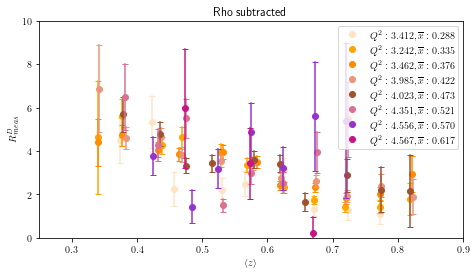

In [9]:

i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[0]].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    xbj_corr_xbj = []
    xbj_err_xbj = []
    Q2_corr_xbj = []
    Q2_err_xbj = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["RD_rho"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = float(RunGroup_value["Q2_corr"])
            Q2i_corr_err = float(RunGroup_value["Q2_corr_err"])
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr_z = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        Q2_err_z = Get_weighted_sigma(Q2s_corr,Q2s_corr_err)
        Q2_corr_xbj.append(Q2_corr_z)
        Q2_err_xbj.append(Q2_err_z)
        xbj_corr_z = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_corr_err_z = Get_weighted_sigma(xbjs_corr,xbjs_corr_err)
        xbj_corr_xbj.append(xbj_corr_z)
        xbj_err_xbj.append(xbj_corr_err_z)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    Q2_corr = Get_weighted_average(Q2_corr_xbj,Q2_err_xbj)
    xbj_corr = Get_weighted_average(xbj_corr_xbj,xbj_err_xbj)
    plt.plot(z_corrs,RD_alls,"o",label = f"$Q^2:{Q2_corr:.3f},\overline{{x}} :{xbj_corr:.3f}$",color = colors_all[i_color])#Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    plt.ylim(0,10)
    plt.title("Rho subtracted")
    i_color +=1
    
    plt.savefig(f"results/RDmeas_1stQ2_rho_Q2center.pdf")

In [10]:

def delta_udv(parameter):
    #x = np.arange(0.2,0.7,0.01)
    x = np.linspace(0.2,0.7,50)
    return parameter*(1-x)**4*x**-0.5*(x-0.0909)
#x_axis = np.arange(0.2,0.7,0.01)
x_axis = np.linspace(0.2,0.7,50)
y_delta_uv = delta_udv(-0.2)
y_delta_dv = delta_udv(0.2)
y_delta_uv_up = delta_udv(0.8)
y_delta_uv_low = delta_udv(-0.8)
y_delta_dv_up = delta_udv(-0.65)
y_delta_dv_low = delta_udv(0.65)

Text(0, 0.5, 'CSV')

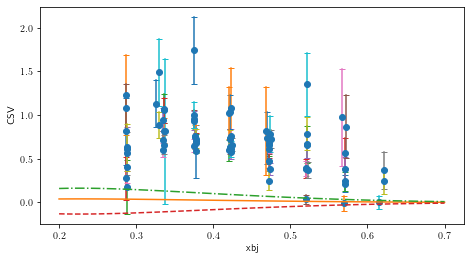

In [11]:
#print(CSVs)
ax = fig.add_subplot()
for i in range(len(CSVs_err)):
    plt.plot([xbj_all_corr[i],xbj_all_corr[i]],[CSVs[i]-CSVs_err[i],CSVs[i]+CSVs_err[i]],marker = "_")    
plt.plot(xbj_all_corr,CSVs,"o")
        #CSVs_err
#print(xbj_all_corr)
    
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV')


plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.xlabel('xbj')
plt.ylabel('CSV')
#plt.ylim(-0.1,0.15)

265
5.157061146633376


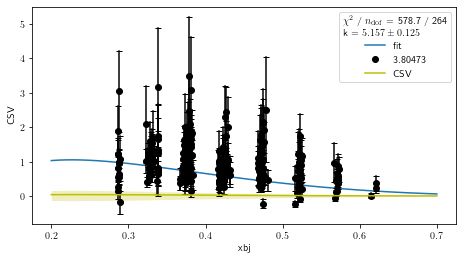

In [12]:
print(len(CSV_ones))
fig, ax = plt.subplots()
least_squares_one = LeastSquares(xbj_ones_corr,CSV_ones,CSV_ones_err,MRST_CSV)
m_one = Minuit(least_squares_one, k=0.2)
m_one.migrad()  # finds minimum of least_squares function
m_one.hesse()   # accurately computes uncertainties
print(*m_one.values)
fit_CSV_one=[]
xbj_axis = np.linspace(0.2,0.7,50)
#for xi in xbj_ones_corr:
for xi in xbj_axis:
    fit_CSV_one.append(MRST_CSV(xi,*m_one.values))


#plt.plot(xbj_ones_corr, fit_CSV_one, label="fit")
plt.plot(xbj_axis, fit_CSV_one, label="fit")


# display legend with some fit info
fit_info_one = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_one.fval:.1f} / {len(xbj_ones_corr) - m_one.nfit}",
]
for p_one, v_one, e_one in zip(m_one.parameters, m_one.values, m_one.errors):
    fit_info_one.append(f"{p_one} = ${v_one:.3f} \\pm {e_one:.3f}$")



for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "k")
plt.plot(xbj_ones_corr,CSV_ones,"ko",label = Q2)

#print(xbj_ones_corr)
    

ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')
plt.legend(title="\n".join(fit_info_one))


#plt.legend()

265
5.157061146633376


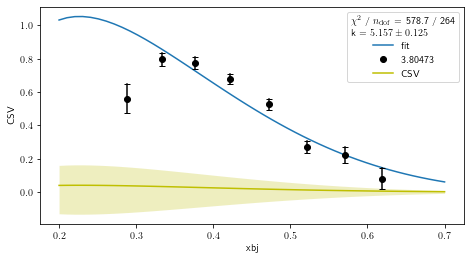

In [13]:
print(len(CSV_ones))
fig, ax = plt.subplots()
least_squares_one = LeastSquares(xbj_ones_corr,CSV_ones,CSV_ones_err,MRST_CSV)
m_one = Minuit(least_squares_one, k=0.2)
m_one.migrad()  # finds minimum of least_squares function
m_one.hesse()   # accurately computes uncertainties
print(*m_one.values)
fit_CSV_one=[]
xbj_axis = np.linspace(0.2,0.7,50)
#for xi in xbj_ones_corr:
for xi in xbj_axis:
    fit_CSV_one.append(MRST_CSV(xi,*m_one.values))


#plt.plot(xbj_ones_corr, fit_CSV_one, label="fit")
plt.plot(xbj_axis, fit_CSV_one, label="fit")


# display legend with some fit info
fit_info_one = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_one.fval:.1f} / {len(xbj_ones_corr) - m_one.nfit}",
]
for p_one, v_one, e_one in zip(m_one.parameters, m_one.values, m_one.errors):
    fit_info_one.append(f"{p_one} = ${v_one:.3f} \\pm {e_one:.3f}$")



for i in range(len(CSV_ones_plot)):
    plt.plot([xbj_ones_plot[i],xbj_ones_plot[i]],[CSV_ones_plot[i]-CSV_ones_err_plot[i],CSV_ones_plot[i]+CSV_ones_err_plot[i]],marker = "_",color = "k")
plt.plot(xbj_ones_plot,CSV_ones_plot,"ko",label = Q2)

#print(xbj_ones_corr)
    

ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')
plt.legend(title="\n".join(fit_info_one))


#plt.legend()

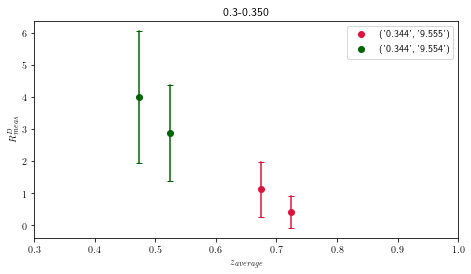

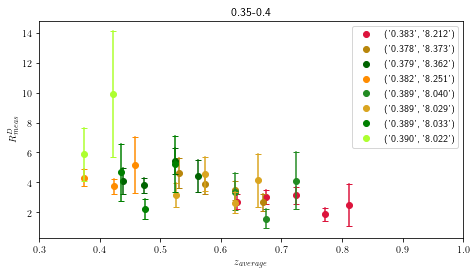

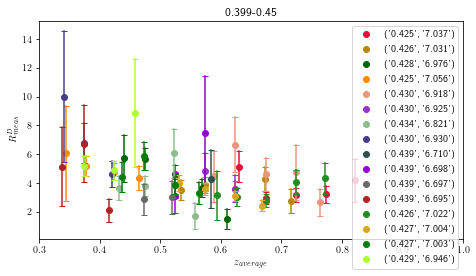

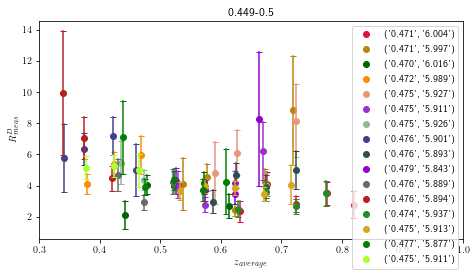

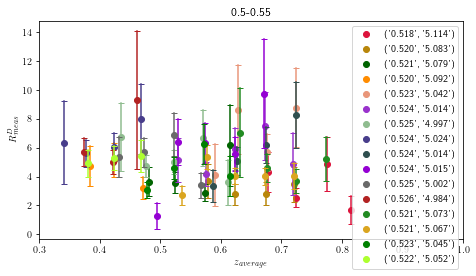

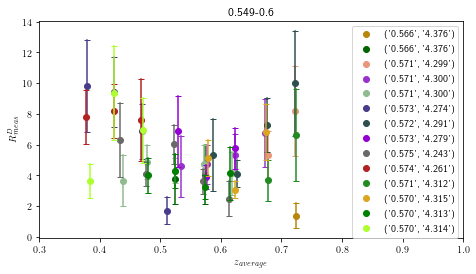

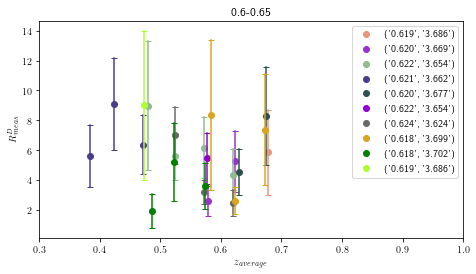

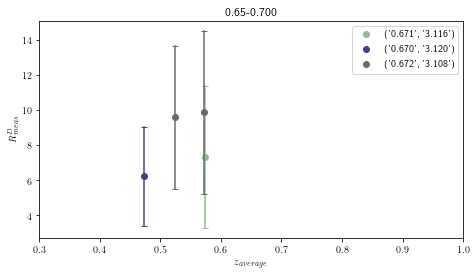

In [14]:
Q2 = Q2s[1]
for key_xbj,xbj_value in RDxz[Q2_str[1]].items():
   
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    #color = ['b','g','r','c','m','y','firebrick','salmon','sienna','orange','tan','peachpuff','teal','hotpink']
    for key_rungroup,rungroup_value in xbj_value.items():
        RunGroup = int(key_rungroup)
        zs = []
        RDs = []
        RDs_error = []
        #print(RunGroup)
        xbj_corrs = []
        xbj_corr_errs = []
        for key_z, z_value in rungroup_value.items():
            z_hadron = float(key_z)#+0.0001*RunGroup
            #print(z_hadron)
            #zs.append(z_hadron)
            RDi=float(z_value["value"])
            RDi_error = float(z_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(z_value["z_corr"])
            zs.append(zi_corr)
            xbji_corr = float(z_value["xbj_corr"])
            xbji_corr_err = float(z_value["xbj_corr_err"])
            xbj_corrs.append(xbji_corr)
            xbj_corr_errs.append(xbji_corr_err)
            ax.plot([zi_corr,zi_corr],[RDi+RDi_error,RDi-RDi_error],marker="_",color = colors[RunGroup//10])
        
        xbj_corr = Get_weighted(xbj_corrs,xbj_corr_errs)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_corr_str = str(xbj_corr)
        plt.plot(zs,RDs,"o",color = colors[RunGroup//10],label = (xbj_corr_str[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])


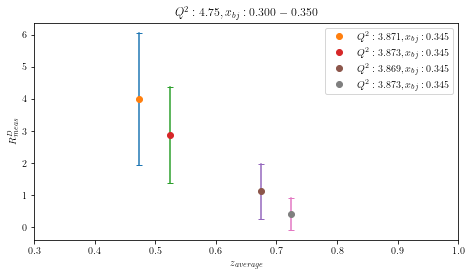

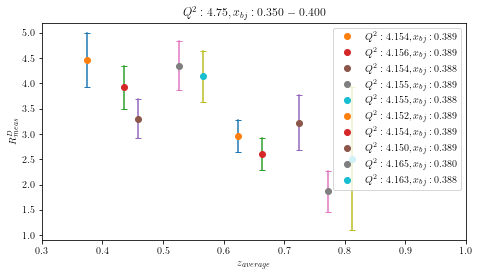

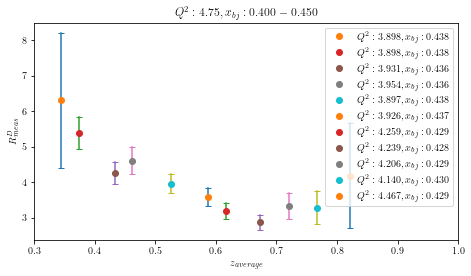

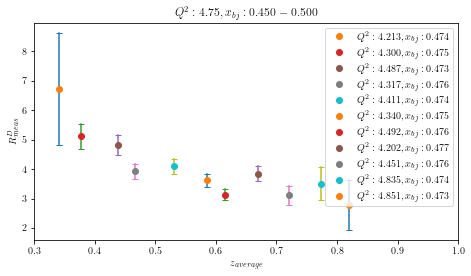

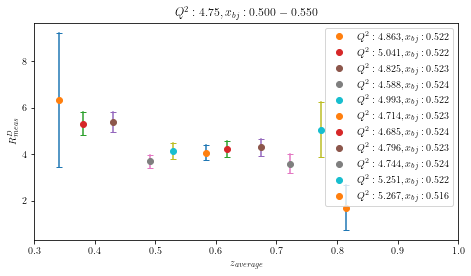

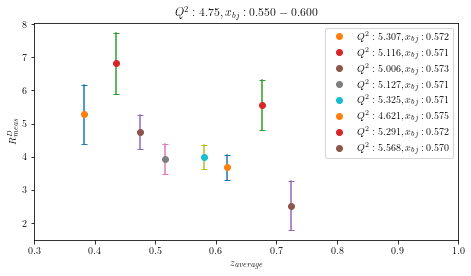

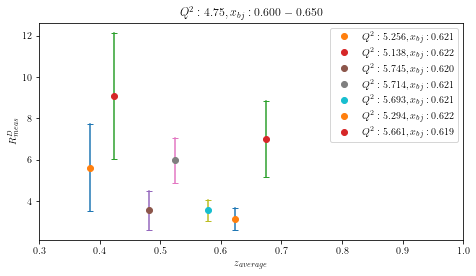

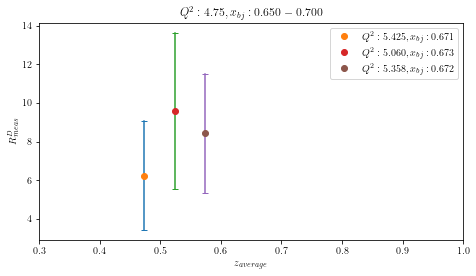

In [15]:
CSVs = []
CSVs_err = []
xbj_all_corr=[]
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[1]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    xbj_two_corr = []
    xbj_two_err_corr = []
    CSV_two = []
    CSV_two_err = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = float(RunGroup_value["Q2_corr"])
            Q2i_corr_err = float(RunGroup_value["Q2_corr_err"])
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            if Q2i_corr<3:
                print(Q2i_corr)
            
            CSVxzi = CSVx(math.sqrt(Q2i_corr),zi_corr,xbji_corr,RDi)
            CSVxzi_err = CSVx_err(math.sqrt(Q2i_corr),zi_corr,xbji_corr,RDi_error)
            CSV_twos.append(CSVxzi)
            CSV_twos_err.append(CSVxzi_err)
            xbj_twos_corr.append(xbji_corr)
            
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        if Q2_corr<3:
            print("corr ",Q2_corr)
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_all_corr.append(xbj_corr)
        CSVxi = CSVx(math.sqrt(Q2_corr),z_corr,xbj_corr,RD)
        CSVxi_err = CSVx_err(math.sqrt(Q2_corr),z_corr,xbj_corr,RD_err)
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_two_corr.append(xbj_corr)
        xbj_twoi_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_two_err_corr.append(xbj_twoi_err_corr)
        CSV_two.append(CSVxi)
        CSV_two_err.append(CSVxi_err)
        ax.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_")
        plt.plot(z_corr,RD,"o",label = f"$Q^2:{Q2_corr:.3f},x_{{bj}}:{xbj_corr:.3f}$")
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(f"$Q^2:{Q2_str[1][0:4]},x_{{bj}}:{(xbj-0.025):.3f}-{(xbj+0.025):.3f}$")
    xbj_two = Get_weighted_average(xbj_two_corr,xbj_two_err_corr)
    xbj_twos_plot.append(xbj_two)
    xbj_two_err = Get_weighted_sigma(xbj_two_corr,xbj_two_err_corr)
    #xbj_twos_err.append(xbj_two_err)
    CSVxi_two = Get_weighted_average(CSV_two,CSV_two_err)
    CSVxi_two_err = Get_weighted_sigma(CSV_two,CSV_two_err)
    #print(CSV_two_err)
    #print(CSVxi_two_err)
    CSV_twos_plot.append(CSVxi_two)
    CSV_twos_err_plot.append(CSVxi_two_err)

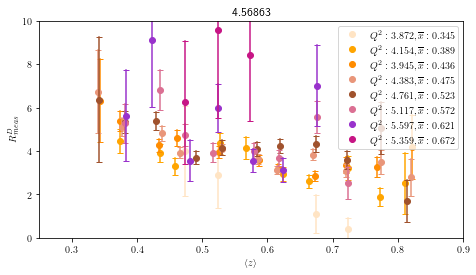

In [16]:

i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[1]].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    xbj_corr_xbj = []
    xbj_err_xbj = []
    Q2_corr_xbj = []
    Q2_err_xbj = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = float(RunGroup_value["Q2_corr"])
            Q2i_corr_err = float(RunGroup_value["Q2_corr_err"])
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr_z = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        Q2_err_z = Get_weighted_sigma(Q2s_corr,Q2s_corr_err)
        Q2_corr_xbj.append(Q2_corr_z)
        Q2_err_xbj.append(Q2_err_z)
        xbj_corr_z = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_corr_err_z = Get_weighted_sigma(xbjs_corr,xbjs_corr_err)
        xbj_corr_xbj.append(xbj_corr_z)
        xbj_err_xbj.append(xbj_corr_err_z)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    Q2_corr = Get_weighted_average(Q2_corr_xbj,Q2_err_xbj)
    xbj_corr = Get_weighted_average(xbj_corr_xbj,xbj_err_xbj)
    plt.plot(z_corrs,RD_alls,"o",label = f"$Q^2:{Q2_corr:.3f},\overline{{x}} :{xbj_corr:.3f}$",color = colors_all[i_color])#Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    plt.ylim(0,10)
    plt.title(Q2)
    i_color +=1
    plt.savefig(f"results/RDmeas_2ndQ2_Q2center.pdf")

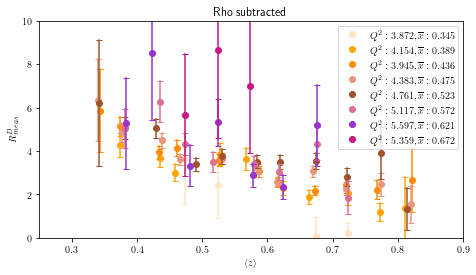

In [17]:

i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[1]].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    xbj_corr_xbj = []
    xbj_err_xbj = []
    Q2_corr_xbj = []
    Q2_err_xbj = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["RD_rho"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = float(RunGroup_value["Q2_corr"])
            Q2i_corr_err = float(RunGroup_value["Q2_corr_err"])
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr_z = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        Q2_err_z = Get_weighted_sigma(Q2s_corr,Q2s_corr_err)
        Q2_corr_xbj.append(Q2_corr_z)
        Q2_err_xbj.append(Q2_err_z)
        xbj_corr_z = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_corr_err_z = Get_weighted_sigma(xbjs_corr,xbjs_corr_err)
        xbj_corr_xbj.append(xbj_corr_z)
        xbj_err_xbj.append(xbj_corr_err_z)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    Q2_corr = Get_weighted_average(Q2_corr_xbj,Q2_err_xbj)
    xbj_corr = Get_weighted_average(xbj_corr_xbj,xbj_err_xbj)
    plt.plot(z_corrs,RD_alls,"o",label = f"$Q^2:{Q2_corr:.3f},\overline{{x}} :{xbj_corr:.3f}$",color = colors_all[i_color])#Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    plt.ylim(0,10)
    plt.title("Rho subtracted")
    i_color +=1
    plt.savefig(f"results/RDmeas_2ndQ2_rho_Q2center.pdf")

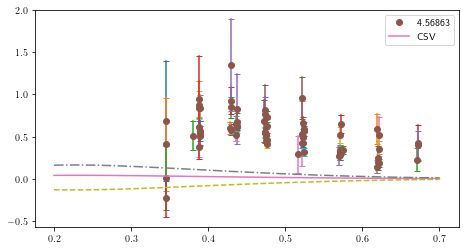

In [18]:
ax = fig.add_subplot()
for i in range(len(CSVs_err)):
    plt.plot([xbj_all_corr[i],xbj_all_corr[i]],[CSVs[i]-CSVs_err[i],CSVs[i]+CSVs_err[i]],marker = "_")
plt.plot(xbj_all_corr,CSVs,"o",label = Q2)
        #CSVs_err
    

#x_axis = np.linspace(0.2,0.7,50)
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV')

#plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.legend()

6.0673946558665035


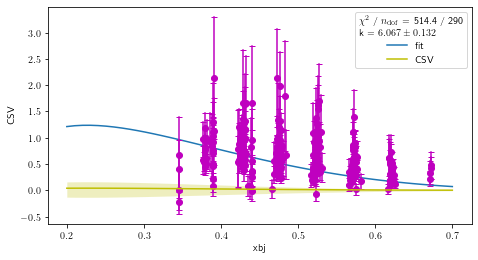

In [19]:
fig, ax = plt.subplots()
least_squares_two = LeastSquares(xbj_twos_corr,CSV_twos,CSV_twos_err,MRST_CSV)
m_two = Minuit(least_squares_two, k=0.2)
m_two.migrad()  # finds minimum of least_squares function
m_two.hesse()   # accurately computes uncertainties
print(*m_two.values)
fit_CSV_two=[]

#for xi in xbj_ones_corr:
for xi in xbj_axis:
    fit_CSV_two.append(MRST_CSV(xi,*m_two.values))


#plt.plot(xbj_ones_corr, fit_CSV_one, label="fit")
plt.plot(xbj_axis, fit_CSV_two, label="fit")


# display legend with some fit info
fit_info_two = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_two.fval:.1f} / {len(xbj_twos_corr) - m_two.nfit}",
]
for p_two, v_two, e_two in zip(m_two.parameters, m_two.values, m_two.errors):
    fit_info_two.append(f"{p_two} = ${v_two:.3f} \\pm {e_two:.3f}$")


for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo")
        

ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')

plt.legend(title="\n".join(fit_info_two))
#plt.legend()

6.0673946558665035


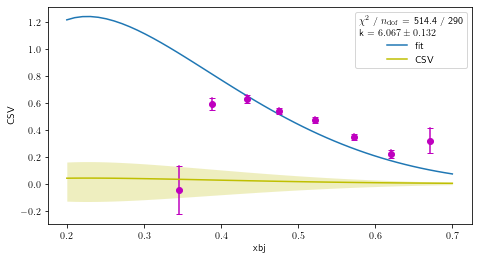

In [20]:
fig, ax = plt.subplots()
least_squares_two = LeastSquares(xbj_twos_corr,CSV_twos,CSV_twos_err,MRST_CSV)
m_two = Minuit(least_squares_two, k=0.2)
m_two.migrad()  # finds minimum of least_squares function
m_two.hesse()   # accurately computes uncertainties
print(*m_two.values)
fit_CSV_two=[]

#for xi in xbj_ones_corr:
for xi in xbj_axis:
    fit_CSV_two.append(MRST_CSV(xi,*m_two.values))


#plt.plot(xbj_ones_corr, fit_CSV_one, label="fit")
plt.plot(xbj_axis, fit_CSV_two, label="fit")


# display legend with some fit info
fit_info_two = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_two.fval:.1f} / {len(xbj_twos_corr) - m_two.nfit}",
]
for p_two, v_two, e_two in zip(m_two.parameters, m_two.values, m_two.errors):
    fit_info_two.append(f"{p_two} = ${v_two:.3f} \\pm {e_two:.3f}$")


for i in range(len(CSV_twos_plot)):
    plt.plot([xbj_twos_plot[i],xbj_twos_plot[i]],[CSV_twos_plot[i]-CSV_twos_err_plot[i],CSV_twos_plot[i]+CSV_twos_err_plot[i]],marker = "_",color = "m")
plt.plot(xbj_twos_plot,CSV_twos_plot,"mo")
        

ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')

plt.legend(title="\n".join(fit_info_two))
#plt.legend()

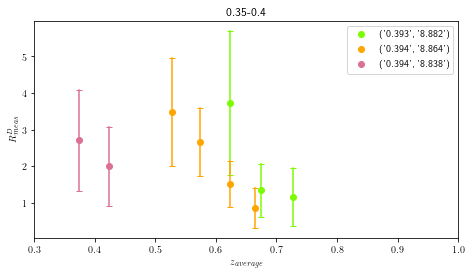

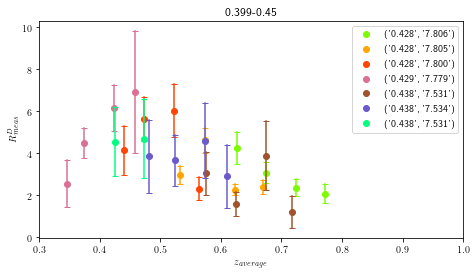

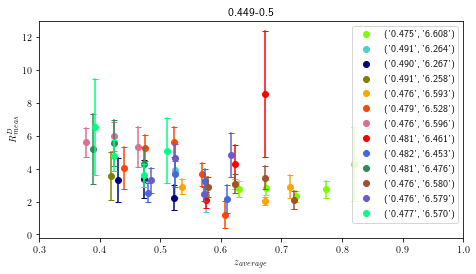

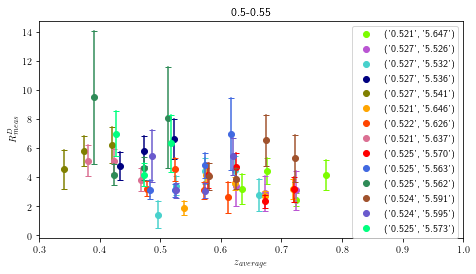

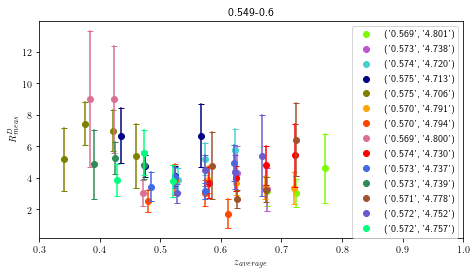

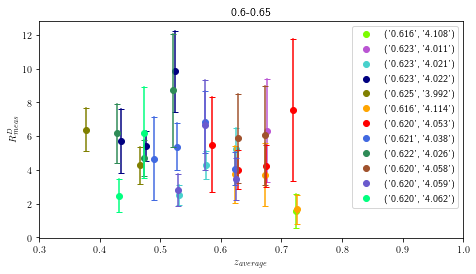

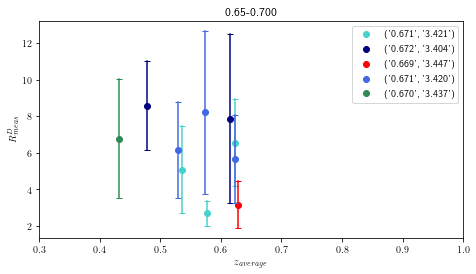

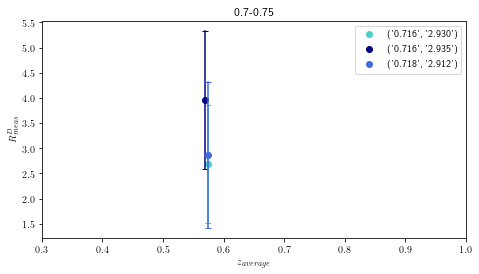

In [21]:
Q2 = Q2s[2]
for key_xbj,xbj_value in RDxz[Q2_str[2]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    #color = ['b','g','r','c','m','y','firebrick','salmon','sienna','orange','tan','peachpuff','teal','hotpink']
    for key_rungroup,rungroup_value in xbj_value.items():
        RunGroup = int(key_rungroup)
        zs = []
        RDs = []
        RDs_error = []
        #print(RunGroup)
        xbj_corrs = []
        xbj_corr_errs = []
        for key_z, z_value in rungroup_value.items():
            z_hadron = float(key_z)#+0.0001*RunGroup
            #print(z_hadron)
            #zs.append(z_hadron)
            RD=float(z_value["value"])
            RD_error = float(z_value["error"])
            RDs.append(float(z_value["value"]))
            RDs_error.append(float(z_value["error"]))
            z_corr = float(z_value["z_corr"])
            zs.append(z_corr)
            xbj_corr = float(z_value["xbj_corr"])
            xbj_corr_err = float(z_value["xbj_corr_err"])
            xbj_corrs.append(xbj_corr)
            xbj_corr_errs.append(xbj_corr_err)
            ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        
        xbj_corr = Get_weighted(xbj_corrs,xbj_corr_errs)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_corr_str = str(xbj_corr)
        plt.plot(zs,RDs,"o",color = colors[RunGroup//10],label = (xbj_corr_str[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])


      


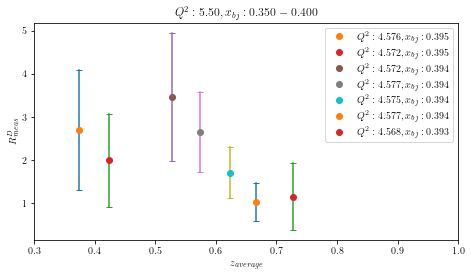

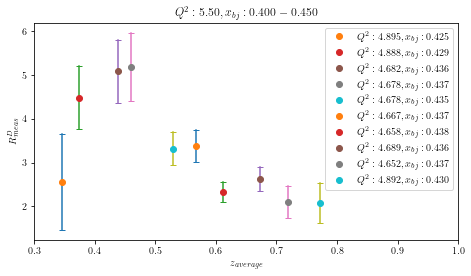

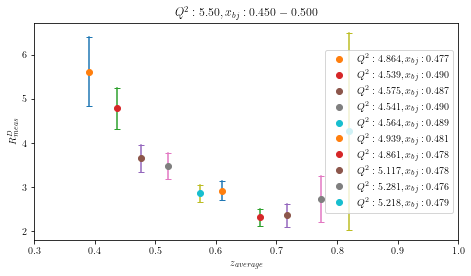

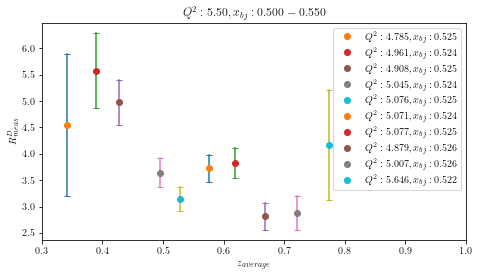

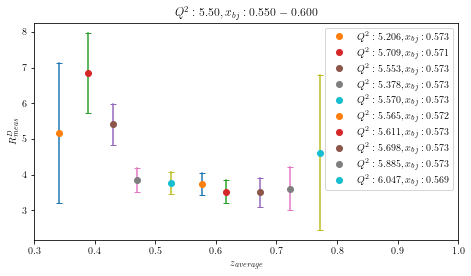

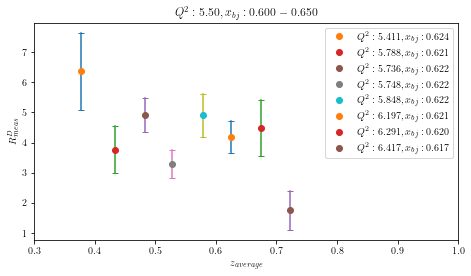

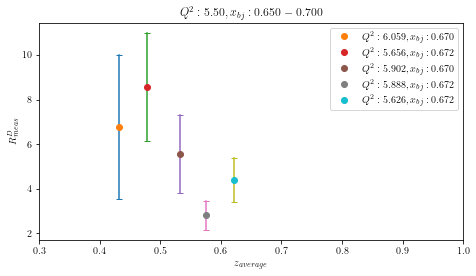

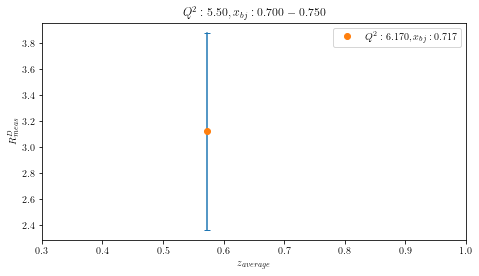

In [22]:

CSVs = []
CSVs_err = []
xbj_all_corr=[]
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[2]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    xbj_three_corr = []
    xbj_three_err_corr = []
    CSV_three = []
    CSV_three_err = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = float(RunGroup_value["Q2_corr"])
            Q2i_corr_err = float(RunGroup_value["Q2_corr_err"])
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            if Q2i_corr<3:
                print(Q2i_corr)
                
            CSVxzi = CSVx(math.sqrt(Q2i_corr),zi_corr,xbji_corr,RDi)
            CSVxzi_err = CSVx_err(math.sqrt(Q2i_corr),zi_corr,xbji_corr,RDi_error)
            CSV_threes.append(CSVxzi)
            CSV_threes_err.append(CSVxzi_err)
            xbj_threes_corr.append(xbji_corr)
            
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        Q2_corr = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        if Q2_corr<3:
            print("corr ",Q2_corr)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_all_corr.append(xbj_corr)
        CSVxi = CSVx(math.sqrt(Q2_corr),z_corr,xbj_corr,RD)
        CSVxi_err = CSVx_err(math.sqrt(Q2_corr),z_corr,xbj_corr,RD_err)
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_three_corr.append(xbj_corr)
        xbj_threei_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_three_err_corr.append(xbj_threei_err_corr)
        CSV_three.append(CSVxi)
        CSV_three_err.append(CSVxi_err)
        ax.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_")
        plt.plot(z_corr,RD,"o",label = f"$Q^2:{Q2_corr:.3f},x_{{bj}}:{xbj_corr:.3f}$")
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(f"$Q^2:{Q2_str[2][0:4]},x_{{bj}}:{(xbj-0.025):.3f}-{(xbj+0.025):.3f}$")
    xbj_three = Get_weighted_average(xbj_three_corr,xbj_three_err_corr)
    xbj_threes_plot.append(xbj_three)
    xbj_three_err = Get_weighted_average(xbj_three_corr,xbj_three_err_corr)
    xbj_threes_err.append(xbj_three_err)
    CSVxi_three = Get_weighted_average(CSV_three,CSV_three_err)
    CSVxi_three_err = Get_weighted_sigma(CSV_three,CSV_three_err)
    CSV_threes_plot.append(CSVxi_three)
    CSV_threes_err_plot.append(CSVxi_three_err)

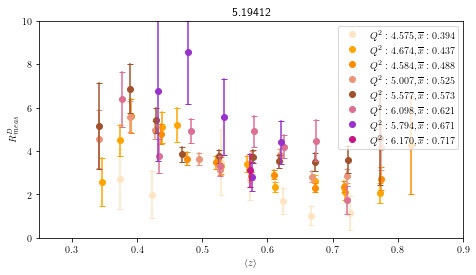

In [23]:

i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[2]].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    xbj_corr_xbj = []
    xbj_err_xbj = []
    Q2_corr_xbj = []
    Q2_err_xbj = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = float(RunGroup_value["Q2_corr"])
            Q2i_corr_err = float(RunGroup_value["Q2_corr_err"])
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr_z = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        Q2_err_z = Get_weighted_sigma(Q2s_corr,Q2s_corr_err)
        Q2_corr_xbj.append(Q2_corr_z)
        Q2_err_xbj.append(Q2_err_z)
        xbj_corr_z = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_corr_err_z = Get_weighted_sigma(xbjs_corr,xbjs_corr_err)
        xbj_corr_xbj.append(xbj_corr_z)
        xbj_err_xbj.append(xbj_corr_err_z)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    Q2_corr = Get_weighted_average(Q2_corr_xbj,Q2_err_xbj)
    xbj_corr = Get_weighted_average(xbj_corr_xbj,xbj_err_xbj)
    plt.plot(z_corrs,RD_alls,"o",label = f"$Q^2:{Q2_corr:.3f},\overline{{x}} :{xbj_corr:.3f}$",color = colors_all[i_color])#Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    plt.ylim(0,10)
    plt.title(Q2)
    i_color +=1
    plt.savefig(f"results/RDmeas_3rdQ2_Q2center.pdf")

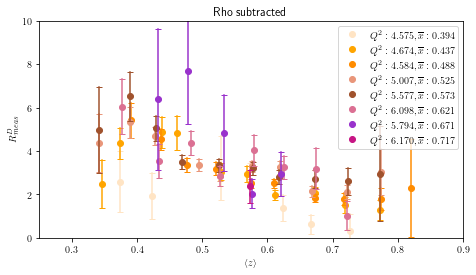

In [24]:

i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[2]].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    xbj_corr_xbj = []
    xbj_err_xbj = []
    Q2_corr_xbj = []
    Q2_err_xbj = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["RD_rho"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = float(RunGroup_value["Q2_corr"])
            Q2i_corr_err = float(RunGroup_value["Q2_corr_err"])
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr_z = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        Q2_err_z = Get_weighted_sigma(Q2s_corr,Q2s_corr_err)
        Q2_corr_xbj.append(Q2_corr_z)
        Q2_err_xbj.append(Q2_err_z)
        xbj_corr_z = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_corr_err_z = Get_weighted_sigma(xbjs_corr,xbjs_corr_err)
        xbj_corr_xbj.append(xbj_corr_z)
        xbj_err_xbj.append(xbj_corr_err_z)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    Q2_corr = Get_weighted_average(Q2_corr_xbj,Q2_err_xbj)
    xbj_corr = Get_weighted_average(xbj_corr_xbj,xbj_err_xbj)
    plt.plot(z_corrs,RD_alls,"o",label = f"$Q^2:{Q2_corr:.3f},\overline{{x}} :{xbj_corr:.3f}$",color = colors_all[i_color])#Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    plt.ylim(0,10)
    plt.title("Rho subtracted")
    i_color +=1
    plt.savefig(f"results/RDmeas_3rdQ2_rho_Q2center.pdf")

Text(0.5, 0, '$x_{bj}$')

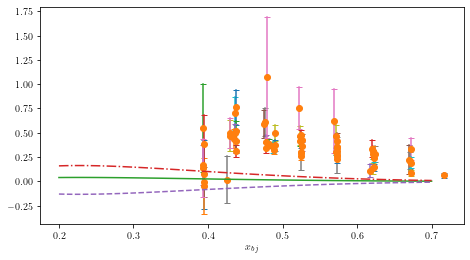

In [25]:
ax = fig.add_subplot()
for i in range(len(CSVs_err)):
    plt.plot([xbj_all_corr[i],xbj_all_corr[i]],[CSVs[i]-CSVs_err[i],CSVs[i]+CSVs_err[i]],marker = "_")
plt.plot(xbj_all_corr,CSVs,"o")
        #CSVs_err
    


plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV')

#plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.xlabel(r'$x_{bj}$')
#plt.ylim(-0.3,0.6)

5.188490951461703


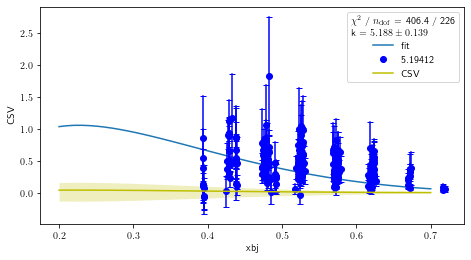

In [26]:
fig, ax = plt.subplots()
least_squares_three = LeastSquares(xbj_threes_corr,CSV_threes,CSV_threes_err,MRST_CSV)
m_three = Minuit(least_squares_three, k=0.2)
m_three.migrad()  # finds minimum of least_squares function
m_three.hesse()   # accurately computes uncertainties
print(*m_three.values)
fit_CSV_three=[]

#for xi in xbj_ones_corr:
for xi in xbj_axis:
    fit_CSV_three.append(MRST_CSV(xi,*m_three.values))


#plt.plot(xbj_ones_corr, fit_CSV_one, label="fit")
plt.plot(xbj_axis, fit_CSV_three, label="fit")


# display legend with some fit info
fit_info_three = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_three.fval:.1f} / {len(xbj_threes_corr) - m_three.nfit}",
]
for p_three, v_three, e_three in zip(m_three.parameters, m_three.values, m_three.errors):
    fit_info_three.append(f"{p_three} = ${v_three:.3f} \\pm {e_three:.3f}$")





for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "b")
plt.plot(xbj_threes_corr,CSV_threes,"bo",label = Q2)
        
ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')

plt.legend(title="\n".join(fit_info_three))



5.188490951461703


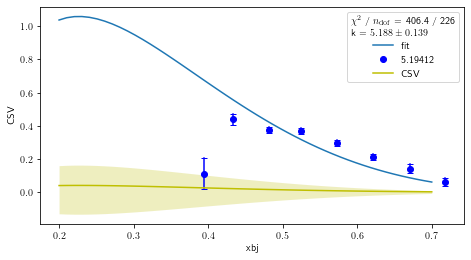

In [27]:
fig, ax = plt.subplots()
least_squares_three = LeastSquares(xbj_threes_corr,CSV_threes,CSV_threes_err,MRST_CSV)
m_three = Minuit(least_squares_three, k=0.2)
m_three.migrad()  # finds minimum of least_squares function
m_three.hesse()   # accurately computes uncertainties
print(*m_three.values)
fit_CSV_three=[]

#for xi in xbj_ones_corr:
for xi in xbj_axis:
    fit_CSV_three.append(MRST_CSV(xi,*m_three.values))


#plt.plot(xbj_ones_corr, fit_CSV_one, label="fit")
plt.plot(xbj_axis, fit_CSV_three, label="fit")


# display legend with some fit info
fit_info_three = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_three.fval:.1f} / {len(xbj_threes_corr) - m_three.nfit}",
]
for p_three, v_three, e_three in zip(m_three.parameters, m_three.values, m_three.errors):
    fit_info_three.append(f"{p_three} = ${v_three:.3f} \\pm {e_three:.3f}$")





for i in range(len(CSV_threes_plot)):
    plt.plot([xbj_threes_plot[i],xbj_threes_plot[i]],[CSV_threes_plot[i]-CSV_threes_err_plot[i],CSV_threes_plot[i]+CSV_threes_err_plot[i]],marker = "_",color = "b")
plt.plot(xbj_threes_plot,CSV_threes_plot,"bo",label = Q2)
        
ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')

plt.legend(title="\n".join(fit_info_three))



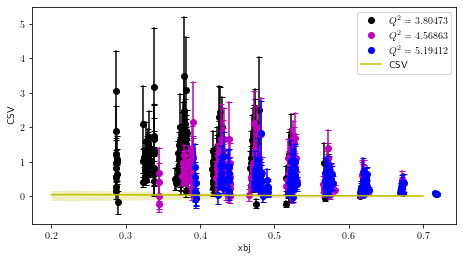

In [28]:
fig, ax = plt.subplots()   
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "k")
plt.plot(xbj_ones_corr,CSV_ones,"ko",label = r'$Q^2 = {}$'.format(Q2s[0]))
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo",label = r'$Q^2 = {}$'.format(Q2s[1]))
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "b")
plt.plot(xbj_threes_corr,CSV_threes,"bo",label = r'$Q^2 = {}$'.format(Q2s[2]))


     
ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')
#plt.ylim(-0.15,0.2)
plt.legend()

In [29]:
#j_CSV2d_out = {}
with open('results/CSVs_2dfit.json') as CSV2d_infile:
    j_CSV2d_out=json.load(CSV2d_infile)

j_CSV2d_out[i_assumption] = {"Q2":Q2s,"xbj_ones":xbj_ones_plot,"CSVs_ones":CSV_ones_plot,"CSVs_ones_errs":CSV_ones_err_plot,"xbj_twos":xbj_twos_plot,"CSVs_twos":CSV_twos_plot,"CSVs_twos_errs":CSV_twos_err_plot,"xbj_threes":xbj_threes_plot,"CSVs_threes":CSV_threes_plot,"CSVs_threes_errs":CSV_threes_err_plot}

with open('results/CSVs_2dfit.json','w') as CSV2d_outfile:
    json.dump(j_CSV2d_out,CSV2d_outfile,indent = 4)
print(xbj_ones_plot)
print(CSV_ones_plot)
print(CSV_ones_err_plot)
print(xbj_twos_plot)
print(CSV_twos_plot)
print(CSV_twos_err_plot)
print(xbj_threes_plot)
print(CSV_threes_plot)
print(CSV_threes_err_plot)

[0.2874835732295815, 0.33357022845595447, 0.37629360484667307, 0.4221592645250666, 0.47210200354521775, 0.5212767887680642, 0.570275105142724, 0.6190451113322896]
[0.5589690075816617, 0.7942221030539013, 0.7731110573573567, 0.6765378788221232, 0.5252921960229237, 0.26813840548368256, 0.22069393796163533, 0.07921993236907511]
[0.08725420355329642, 0.041802550973317455, 0.033326560475825, 0.030379660515417437, 0.03480695485870298, 0.034917559875217156, 0.04832754854594541, 0.06287418352373586]
[0.3449582958353345, 0.38778790010527975, 0.433326328906148, 0.47459460068959514, 0.522349344518779, 0.5718606400398212, 0.6207041958696359, 0.6716679075844669]
[-0.047742126180950265, 0.591745595870479, 0.6254743308957048, 0.535950398149331, 0.47121593458001326, 0.34746212972855844, 0.21914176356811937, 0.31877530601459797]
[0.1788588032491839, 0.04511333934649924, 0.027061928527118643, 0.020296851550379715, 0.020936148246474492, 0.02220264302132628, 0.02690608300543416, 0.09462619578743886]
[0.39

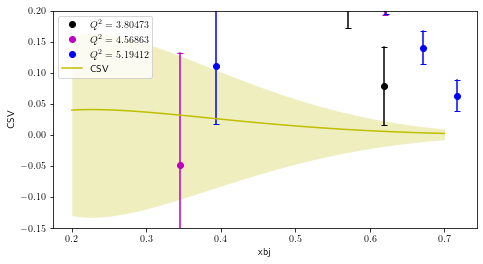

In [30]:
fig, ax = plt.subplots()   
for i in range(len(CSV_ones_plot)):
    plt.plot([xbj_ones_plot[i],xbj_ones_plot[i]],[CSV_ones_plot[i]-CSV_ones_err_plot[i],CSV_ones_plot[i]+CSV_ones_err_plot[i]],marker = "_",color = "k")
plt.plot(xbj_ones_plot,CSV_ones_plot,"ko",label = r'$Q^2 = {}$'.format(Q2s[0]))
for i in range(len(CSV_twos_plot)):
    plt.plot([xbj_twos_plot[i],xbj_twos_plot[i]],[CSV_twos_plot[i]-CSV_twos_err_plot[i],CSV_twos_plot[i]+CSV_twos_err_plot[i]],marker = "_",color = "m")
plt.plot(xbj_twos_plot,CSV_twos_plot,"mo",label = r'$Q^2 = {}$'.format(Q2s[1]))
for i in range(len(CSV_threes_plot)):
    plt.plot([xbj_threes_plot[i],xbj_threes_plot[i]],[CSV_threes_plot[i]-CSV_threes_err_plot[i],CSV_threes_plot[i]+CSV_threes_err_plot[i]],marker = "_",color = "b")
plt.plot(xbj_threes_plot,CSV_threes_plot,"bo",label = r'$Q^2 = {}$'.format(Q2s[2]))


     
ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')
plt.ylim(-0.15,0.2)
plt.legend()
plt.savefig("results/CSV_"+i_assumption+".pdf")

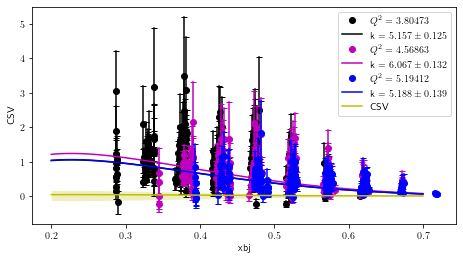

In [31]:
fig, ax = plt.subplots()   
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "k")
plt.plot(xbj_ones_corr,CSV_ones,"ko",label = r'$Q^2 = {}$'.format(Q2s[0]))
plt.plot(xbj_axis, fit_CSV_one, "k",label=f"{p_one} = ${v_one:.3f} \\pm {e_one:.3f}$")
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo",label = r'$Q^2 = {}$'.format(Q2s[1]))
plt.plot(xbj_axis, fit_CSV_two, "m",label=f"{p_two} = ${v_two:.3f} \\pm {e_two:.3f}$")
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "b")
plt.plot(xbj_threes_corr,CSV_threes,"bo",label = r'$Q^2 = {}$'.format(Q2s[2]))
plt.plot(xbj_axis, fit_CSV_three, "b",label=f"{p_three} = ${v_three:.3f} \\pm {e_three:.3f}$")


     
ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')
#plt.ylim(-0.15,0.2)
plt.legend()


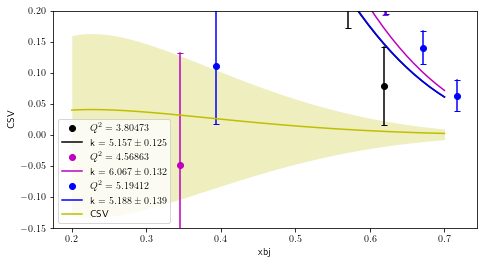

In [32]:
fig, ax = plt.subplots()   
for i in range(len(CSV_ones_plot)):
    plt.plot([xbj_ones_plot[i],xbj_ones_plot[i]],[CSV_ones_plot[i]-CSV_ones_err_plot[i],CSV_ones_plot[i]+CSV_ones_err_plot[i]],marker = "_",color = "k")
plt.plot(xbj_ones_plot,CSV_ones_plot,"ko",label = r'$Q^2 = {}$'.format(Q2s[0]))
plt.plot(xbj_axis, fit_CSV_one, "k",label=f"{p_one} = ${v_one:.3f} \\pm {e_one:.3f}$")
for i in range(len(CSV_twos_plot)):
    plt.plot([xbj_twos_plot[i],xbj_twos_plot[i]],[CSV_twos_plot[i]-CSV_twos_err_plot[i],CSV_twos_plot[i]+CSV_twos_err_plot[i]],marker = "_",color = "m")
plt.plot(xbj_twos_plot,CSV_twos_plot,"mo",label = r'$Q^2 = {}$'.format(Q2s[1]))
plt.plot(xbj_axis, fit_CSV_two, "m",label=f"{p_two} = ${v_two:.3f} \\pm {e_two:.3f}$")
for i in range(len(CSV_threes_plot)):
    plt.plot([xbj_threes_plot[i],xbj_threes_plot[i]],[CSV_threes_plot[i]-CSV_threes_err_plot[i],CSV_threes_plot[i]+CSV_threes_err_plot[i]],marker = "_",color = "b")
plt.plot(xbj_threes_plot,CSV_threes_plot,"bo",label = r'$Q^2 = {}$'.format(Q2s[2]))
plt.plot(xbj_axis, fit_CSV_three, "b",label=f"{p_three} = ${v_three:.3f} \\pm {e_three:.3f}$")

     
ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')
plt.ylim(-0.15,0.2)
plt.legend()
plt.savefig(f"/Users/shuojia/CSV/results/ratios/CSV_all_Q2center_{FF_model[i_FF]}_fit.pdf")

with open('results/CSVs.json') as CSV_infile:
    j_CSV_out=json.load(CSV_infile)
#j_CSV_out = {}
j_CSV_out[FF_model[i_FF]] = {"Q2":Q2s,"xbj_ones":xbj_ones_plot,"CSVs_ones":CSV_ones_plot,"CSVs_ones_errs":CSV_ones_err_plot,"xbj_twos":xbj_twos_plot,"CSVs_twos":CSV_twos_plot,"CSVs_twos_errs":CSV_twos_err_plot,"xbj_threes":xbj_threes_plot,"CSVs_threes":CSV_threes_plot,"CSVs_threes_errs":CSV_threes_err_plot}
#j_CSV_out[str(Q2s[0])]={FF_model[i_FF]:{"xbjs":xbj_ones_plot,"CSVs":CSV_ones_plot,"CSVs_errs":CSV_ones_err_plot}}
#j_CSV_out[str(Q2s[1])]={FF_model[i_FF]:{"xbjs":xbj_twos_plot,"CSVs":CSV_twos_plot,"CSVs_errs":CSV_twos_err_plot}}
#j_CSV_out[str(Q2s[2])]={FF_model[i_FF]:{"xbjs":xbj_threes_plot,"CSVs":CSV_threes_plot,"CSVs_errs":CSV_threes_err_plot}}

with open('results/CSVs.json','w') as CSV_outfile:
    json.dump(j_CSV_out,CSV_outfile,indent = 4)

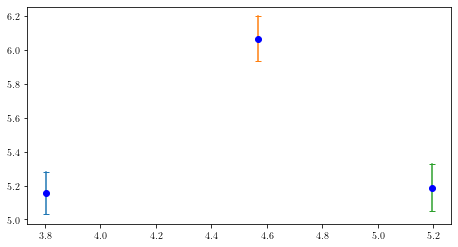

In [33]:
ks = []
kerrs = []
plt.plot([Q2s[0],Q2s[0]],[v_one-e_one,v_one+e_one],marker = "_")
plt.plot(Q2s[0],v_one,"bo")
plt.plot([Q2s[1],Q2s[1]],[v_two-e_two,v_two+e_two],marker = "_")
plt.plot(Q2s[1],v_two,"bo")
plt.plot([Q2s[2],Q2s[2]],[v_three-e_three,v_three+e_three],marker = "_")
plt.plot(Q2s[2],v_three,"bo")
ks.append(v_one)
ks.append(v_two)
ks.append(v_three)
kerrs.append(e_one)
kerrs.append(e_two)
kerrs.append(e_three)

with open('fitting_param.json') as jout_infile:
    jout = json.load(jout_infile)

#jout = {}

jout[FF_model[i_FF]] = {"Q2":Q2s,"k":ks,"kerr":kerrs}
#jout["fDSSNLO"]={"Q2":Q2s,"k":ks,"kerr":kerrs}
#jout["fDSSLO"]={"Q2":Q2s,"k":ks,"kerr":kerrs}
#jout["JAM20"]={"Q2":Q2s,"k":ks,"kerr":kerrs}
#jout["Geiger"]={"Q2":Q2s,"k":ks,"kerr":kerrs}


with open('fitting_param.json','w') as outfile:
    json.dump(jout,outfile,indent = 4)

In [34]:
#ax = fig.add_subplot() This one is wrong. data is CSV, MRST is CSV
'''
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]/xbj_ones_corr[i]-CSV_ones_err[i]/xbj_ones_corr[i],CSV_ones[i]/xbj_ones_corr[i]+CSV_ones_err[i]/xbj_ones_corr[i]],marker = "_",color = "b")
    plt.plot(xbj_ones_corr[i],CSV_ones[i]/xbj_ones_corr[i],"bo")
plt.plot(xbj_ones_corr[1],CSV_ones[1]/xbj_ones_corr[1],"bo",label = r'$Q^2 = 5.5$')
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]/xbj_twos_corr[i]-CSV_twos_err[i]/xbj_twos_corr[i],CSV_twos[i]/xbj_twos_corr[i]+CSV_twos_err[i]/xbj_twos_corr[i]],marker = "_",color = "m")
    plt.plot(xbj_twos_corr[i],CSV_twos[i]/xbj_twos_corr[i],"mo")
plt.plot(xbj_twos_corr[1],CSV_twos[1]/xbj_twos_corr[1],"mo",label = r'$Q^2 = 4.75$')
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]/xbj_threes_corr[i]-CSV_threes_err[i]/xbj_threes_corr[i],CSV_threes[i]/xbj_threes_corr[i]+CSV_threes_err[i]/xbj_threes_corr[i]],marker = "_",color = "k")
    plt.plot(xbj_threes_corr[i],CSV_threes[i]/xbj_threes_corr[i],"ko")
plt.plot(xbj_threes_corr[1],CSV_threes[1]/xbj_threes_corr[1],"ko",label = r'$Q^2 = 4.0$')
plt.grid()       
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV MRST',color = 'r')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.',label = 'MRST limit',color = 'r')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'-.',color = 'r')
plt.xlabel('xbj')
plt.ylabel('CSV')
plt.legend()
'''

'\nfor i in range(len(CSV_ones)):\n    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]/xbj_ones_corr[i]-CSV_ones_err[i]/xbj_ones_corr[i],CSV_ones[i]/xbj_ones_corr[i]+CSV_ones_err[i]/xbj_ones_corr[i]],marker = "_",color = "b")\n    plt.plot(xbj_ones_corr[i],CSV_ones[i]/xbj_ones_corr[i],"bo")\nplt.plot(xbj_ones_corr[1],CSV_ones[1]/xbj_ones_corr[1],"bo",label = r\'$Q^2 = 5.5$\')\nfor i in range(len(CSV_twos)):\n    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]/xbj_twos_corr[i]-CSV_twos_err[i]/xbj_twos_corr[i],CSV_twos[i]/xbj_twos_corr[i]+CSV_twos_err[i]/xbj_twos_corr[i]],marker = "_",color = "m")\n    plt.plot(xbj_twos_corr[i],CSV_twos[i]/xbj_twos_corr[i],"mo")\nplt.plot(xbj_twos_corr[1],CSV_twos[1]/xbj_twos_corr[1],"mo",label = r\'$Q^2 = 4.75$\')\nfor i in range(len(CSV_threes)):\n    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]/xbj_threes_corr[i]-CSV_threes_err[i]/xbj_threes_corr[i],CSV_threes[i]/xbj_threes_corr[i]+CSV_threes_err[i]/xbj_threes_co

In [35]:
xbj_oneall_corr = Get_weighted_average(xbj_ones_corr,xbj_ones_err)
CSV_oneall_corr = Get_weighted_average(CSV_ones,CSV_ones_err)
CSV_oneall_err = Get_weighted_average(CSV_ones,CSV_ones_err)
xbj_twoall_corr = Get_weighted_average(xbj_twos_corr,xbj_twos_err)
CSV_twoall_corr = Get_weighted_average(CSV_twos,CSV_twos_err)
CSV_twoall_err = Get_weighted_average(CSV_twos,CSV_twos_err)
xbj_threeall_corr = Get_weighted_average(xbj_threes_corr,xbj_threes_err)
CSV_threeall_corr = Get_weighted_average(CSV_threes,CSV_threes_err)
CSV_threeall_err = Get_weighted_average(CSV_threes,CSV_threes_err)
plt.plot([xbj_oneall_corr,xbj_oneall_corr],[CSV_oneall_corr-CSV_oneall_err,CSV_oneall_corr+CSV_oneall_err],marker = "_",color = "b")
plt.plot(xbj_oneall_corr,CSV_oneall_corr,"bo",label = r'$Q^2 = 5.5$')
plt.plot([xbj_twoall_corr,xbj_twoall_corr],[CSV_twoall_corr-CSV_twoall_err,CSV_twoall_corr+CSV_twoall_err],marker = "_",color = "m")
plt.plot(xbj_twoall_corr,CSV_twoall_corr,"mo",label = r'$Q^2 = 4.75$')
plt.plot([xbj_threeall_corr,xbj_threeall_corr],[CSV_threeall_corr-CSV_threeall_err,CSV_threeall_corr+CSV_threeall_err],marker = "_",color = "k")
plt.plot(xbj_threeall_corr,CSV_threeall_corr,"ko",label = r'$Q^2 = 4$')

IndexError: list index out of range